In [1]:
import numpy as np
import trimesh
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.utils.vis_utils import plot_model
from random import sample
import random
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def create_vector(a,b,step):
    new_vec = []
    curr_val = a
    while curr_val < b:
        new_vec.append(curr_val)
        curr_val += step
        
    return new_vec

from ipywidgets import *
import visualkeras
from keras import backend as K

def chamfer_distance(y_true, y_pred):
    """
    Compute the Chamfer Distance between two point clouds
    """
    y_true = K.reshape(y_true, shape=(-1, 3))
    y_pred = K.reshape(y_pred, shape=(-1, 3))

    num_points_y_true = tf.shape(y_true)[0]
    num_points_y_pred = tf.shape(y_pred)[0]

    # Compute pairwise distance matrix
    r_true = K.sum(y_true * y_true, axis=1)
    r_true = K.reshape(r_true, [-1, 1])
    r_pred = K.sum(y_pred * y_pred, axis=1)
    r_pred = K.reshape(r_pred, [1, -1])

    D = r_true - 2 * K.dot(y_true, K.transpose(y_pred)) + r_pred

    # Compute the minimum distance for each point in y_true
    min_distance_true = K.min(D, axis=1)

    # Compute the minimum distance for each point in y_pred
    min_distance_pred = K.min(D, axis=0)

    # Compute the Chamfer Distance
    chamfer_distance = 0.5 * (K.mean(min_distance_true) + K.mean(min_distance_pred))

    return chamfer_distance

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.


In [2]:
m = 112

mean_mesh = trimesh.load_mesh('mean.ply')
M = mean_mesh.vertices
original_figures = np.zeros((m, len(M), 3))

for k in range(m):
    stl_mesh = trimesh.load_mesh('surf' + str(1 + k) + '.ply')
    original_figures[k, :, :] = np.array(stl_mesh.vertices)
    T, V_transformed, d = trimesh.registration.procrustes(original_figures[k,:,:], M)
    original_figures[k,:,:] = V_transformed

## Load Voxels

In [3]:
voxel_shapes = np.load("voxelized_meshes.npy")

## Autoencode Latent Shape Space Architecture

In [4]:
encoding_dim = 128

In [5]:
latent_dimension = keras.Input(shape = (128,))
input_point = keras.Input(shape = (3))

complete_input = layers.Concatenate(axis=1)([latent_dimension, input_point])

x = layers.Dense(128 * 16)(complete_input)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128 * 8)(x)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128 * 4)(x)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128 * 2)(x)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
velocity_vector = layers.Dense(3)(x)

im_net = keras.Model(inputs=complete_input, outputs=velocity_vector)

2023-08-09 13:58:41.701522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def mul_sca(x):
    return tf.multiply(x[0],x[1])

net_in = input_point
x = net_in
n = 10
for i in range(n):
    adjust_latent_space = tf.keras.layers.Lambda(mul_sca)([(i + 1) * 1.0 / n, latent_dimension])
    complete_input = layers.Concatenate(axis=1)([latent_dimension, net_in])
    v = im_net(complete_input)
    vt = tf.keras.layers.Lambda(mul_sca)([1.0 / n, v])
    x = tf.keras.layers.Add()([x, vt])

net_out = x

sequence = keras.Model(inputs=[latent_dimension, input_point], outputs=net_out)

In [7]:
sequence.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 131)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 3)            3309443     ['concatenate_5[0][0]',    

                                                                  'input_2[0][0]']                
                                                                                                  
 add_7 (Add)                    (None, 3)            0           ['add_6[0][0]',                  
                                                                  'lambda_15[0][0]']              
                                                                                                  
 lambda_17 (Lambda)             (None, 3)            0           ['model[8][0]']                  
                                                                                                  
 add_8 (Add)                    (None, 3)            0           ['add_7[0][0]',                  
                                                                  'lambda_17[0][0]']              
                                                                                                  
 lambda_19

In [8]:
sequence.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[chamfer_distance])

## Load Latent Space Encoder Model

In [9]:
input_imag = keras.Input(shape = (32,32,32,1))

x = layers.Conv3D(16, (5,5,5))(input_imag)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(1, (5,5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)

encoded = layers.UnitNormalization()(x)

In [10]:
encoder = keras.Model(input_imag, encoded)
encoder = load_model("best_encoder_with_normalization_32.h5")

WARNING - 2023-08-09 13:58:42,063 - hdf5_format - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [11]:
latent_input = keras.Input(shape = (128,))

x = layers.Dense(1728)(latent_input)
x = layers.Reshape((12,12,12,1))(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(1, (9,9,9))(x)
decoded = activations.sigmoid(x)

In [12]:
decoder = keras.Model(latent_input, decoded)
decoder = load_model('best_decoder_with_normalization_32')

WARNING - 2023-08-09 13:58:42,307 - load - No training configuration found in save file, so the model was *not* compiled. Compile it manually.


In [13]:
latent_input = keras.Input(shape = (128,))

x = layers.Dense(1728)(latent_input)
x = layers.Reshape((12,12,12,1))(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(1, (9,9,9))(x)
decoded = activations.sigmoid(x)

## Train / Test Split

In [14]:
random.seed(10)
test_indices = random.sample(range(m),23)
train_indices = list(filter(lambda x : x not in test_indices, range(m)))
val_indices = random.sample(train_indices,11)
train_indices = list(filter(lambda x : x not in val_indices, train_indices))

In [15]:
latent_representation = encoder.predict(voxel_shapes)

4/4 [==============================] - 1s 196ms/step


In [16]:
decoded_representation = decoder.predict(latent_representation)

4/4 [==============================] - 2s 462ms/step


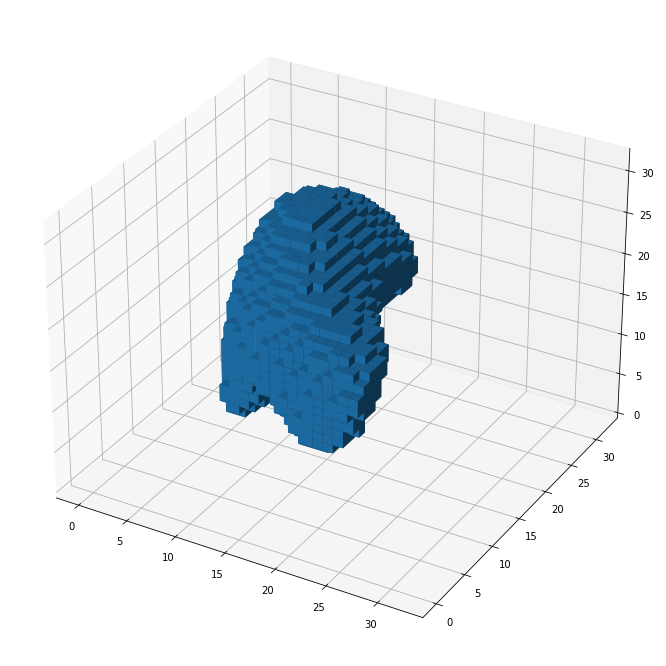

In [17]:
index = 60
voxel1 = decoded_representation[index,:,:,:,0]
mu = np.mean(voxel1.flatten())
sigma = np.std(voxel1.flatten())
carved_voxel = np.zeros(voxel1.shape)

for i in range(32):
    for j in range(32):
        for k in range(32):
            if voxel1[i,j,k] > mu + sigma:
                carved_voxel[i,j,k] = 1
                
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.voxels(carved_voxel)

plt.show()

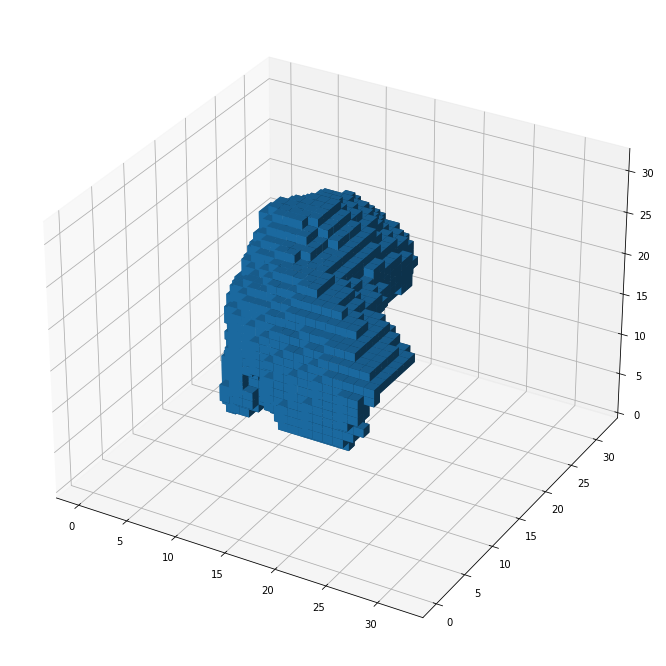

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.voxels(voxel_shapes[index,:,:,:])

plt.show()

## Model Training

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_sequence_model_32.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [20]:
print("Generating Training Set")
    
points = np.zeros((0,3))
latent_dimensions = np.zeros((0,128))
output = np.ones((0,3))
    
for model in train_indices: 

    V = np.copy(original_figures[model, :, :])
                
    points = np.concatenate((points, M))
    output = np.concatenate((output, V))
    latent_dimensions = np.concatenate( (latent_dimensions, np.tile(np.expand_dims(latent_representation[model,:], axis = 0).T, len(M)).T ) )

Generating Training Set


In [21]:
print("Generating Validation Set")
    
val_points = np.zeros((0,3))
val_latent_dimensions = np.zeros((0,128))
val_output = np.ones((0,3))
    
for model in val_indices: 

    V = np.copy(original_figures[model, :, :])
                
    val_points = np.concatenate((val_points, M))
    val_output = np.concatenate((val_output, V))
    val_latent_dimensions = np.concatenate( (val_latent_dimensions, np.tile(np.expand_dims(latent_representation[model,:], axis = 0).T, len(M)).T ) )

Generating Validation Set


In [22]:
sequence.fit([latent_dimensions, points], output, epochs=1, batch_size=len(M), shuffle=True, validation_data=([val_latent_dimensions, val_points], val_output), callbacks=[es,mc])

78/78 [==============================] - ETA: 0s - loss: 0.9868 - chamfer_distance: 0.5251
Epoch 1: val_loss improved from inf to 0.50404, saving model to best_sequence_model_32.h5
78/78 [==============================] - 626s 8s/step - loss: 0.9868 - chamfer_distance: 0.5251 - val_loss: 0.5040 - val_chamfer_distance: 0.5717


## Model Testing

In [23]:
print("Generating Test Set")

test_points = np.zeros((0,3))
test_latent_dimensions = np.zeros((0,128))
test_output = np.ones((0,3))
    
for model in test_indices: 

    V = np.copy(original_figures[model, :, :])
                
    test_points = np.concatenate((test_points, M))
    test_output = np.concatenate((test_output, V))
    test_latent_dimensions = np.concatenate( (test_latent_dimensions, np.tile(np.expand_dims(latent_representation[model,:], axis = 0).T, len(M)).T ) )

Generating Test Set


In [24]:
sequence.load_weights("best_sequence_model_32.h5")

In [25]:
sequence.evaluate([test_latent_dimensions, test_points], test_output, batch_size=len(M), verbose = True) 

23/23 [==============================] - 62s 3s/step - loss: 0.5577 - chamfer_distance: 0.6293


[0.5577229857444763, 0.6292737126350403]

In [26]:
test_predictions = sequence.predict([test_latent_dimensions, test_points])

9326/9326 [==============================] - 82s 9ms/step


## Latent Space Traversal -> Shape Space

In [27]:
bound_x = [-15, 15]
bound_y = [-15, 15]
bound_z = [-15, 15]

In [28]:
X = create_vector(bound_x[0], bound_x[1], 30)
Y = create_vector(bound_y[0], bound_y[1], 30)
Z = create_vector(bound_z[0], bound_z[1], 30)

In [29]:
model_num = 10

In [30]:
latent_dimension = latent_representation[model_num,:]

In [31]:
latent_dimension = latent_dimension.reshape((1,128))

In [32]:
mesh = trimesh.load_mesh('surf' + str(model_num + 1) + '.ply')
V = mesh.vertices

In [33]:
latent_dims = []

for k in range(len(V)):
    latent_dims.append(latent_dimension)
    
latent_dims = np.array(latent_dims)
latent_dims = latent_dims.reshape((len(latent_dims), 128))

In [34]:
latent_dims.shape

(12974, 128)

In [35]:
predictions = sequence.predict([latent_dims, M])

406/406 [==============================] - 4s 9ms/step


In [36]:
predictions = predictions.astype(np.double)

In [37]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(predictions)
geometry = o3d.geometry.PointCloud()
geometry.points = o3d.utility.Vector3dVector(V)
o3d.visualization.draw_geometries([pcd, geometry], mesh_show_back_face=True)

vis = o3d.visualization.Visualizer()
vis.create_window()

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


True

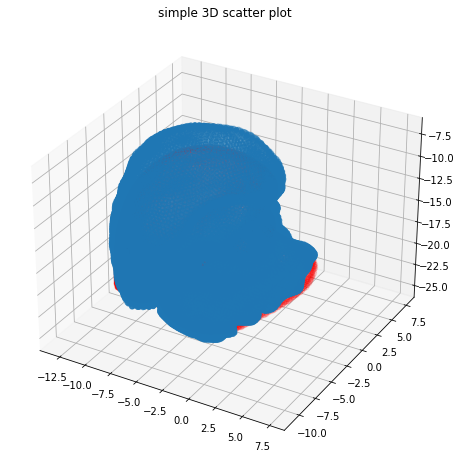

In [38]:
#%matplotlib notebook

# Creating figure
fig = plt.figure(figsize = (12, 8))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(predictions[:,0], predictions[:,1], predictions[:,2], c="r", depthshade=False, alpha = 0.1)
ax.scatter3D(V[:,0], V[:,1], V[:,2])
plt.title("Comparison of Test Shape versus Predicted")

# show plot
plt.show()